In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# The creation of an extremely accurate classifier

In this notebook, we will be trying to create a classifier for predicting individual finger movements from EEG data. Data were preprocessed as follows:

1. The data were **scaled** by performing z-scale transformation for each channel separately.
2. **Power line** noise was removed.
3. Frequencies **lower than 4 Hz** and **higher than 290 Hz** were removed.
4. **Bad quality channels** were detected.
    A channel is considered bad quality if it has low average correlation of the band power with the other channels. The minimum average correlation is determined for each run separately. The correlation is decreased by 0.001 (starting from 1) until the number of channels with lower correlation is less than 25.
5. Bad quality channels **were not removed**.
    The detected bad quality channels were kept because they should not be informative and thus should not be of much use to the classifier. Channel selection will be done for each subsample separately and these channels should be dropped during the process.
6. Data were subdivided into **epochs** and the **features** for the classifier were extracted.
    The data were cut into epochs of 0.5 seconds. For each of these epochs, the absolute power was calculated in the frequency bands from 5 Hz to 100 Hz with a step of 5 Hz.
7. Features of different runs from the same person were joined together.

The classifier described were performs supervised learning and predicts categorical value for each epoch (thumb, index, middle, ring, pinky, no finger).

In [2]:
feature_matrix = pd.read_csv('output/problem-at-hand/S2/all/feature_matrix.csv', index_col = 0)
key = pd.read_csv('output/problem-at-hand/S2/all/key.csv')

In [3]:
print(f'The feature matrix has {feature_matrix.shape[0]} features and {feature_matrix.shape[1]} epochs.')
print('Reminder: a feature in this case is a specific power band frequency from a specific channel, e.g. X0_5: absolute power of 5-10 Hz band in channel X0.')

The feature matrix has 4864 features and 4150 epochs.
Reminder: a feature in this case is a specific power band frequency from a specific channel, e.g. X0_5: absolute power of 5-10 Hz band in channel X0.


In [4]:
key

,EventID,Run,Event
0,Event0_run1,run1,0.0
1,Event1_run1,run1,0.0
2,Event2_run1,run1,0.0
3,Event3_run1,run1,0.0
4,Event4_run1,run1,0.0
...,...,...,...
4145,Event410_run10,run10,6.0
4146,Event411_run10,run10,6.0
4147,Event412_run10,run10,6.0
4148,Event413_run10,run10,6.0


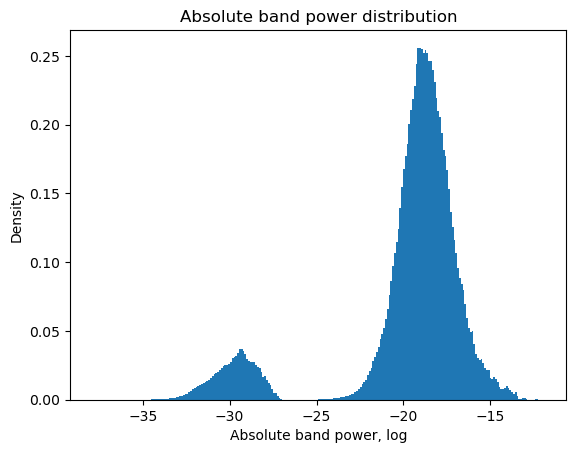

In [5]:
plt.hist(np.log(feature_matrix.values.flatten()), bins = 250, density = True)
plt.xlabel('Absolute band power, log')
plt.ylabel('Density')
plt.title('Absolute band power distribution')
plt.show()

After natural log transformation, the complete dataset displays a bimodal distribution. However, the data in each individual channel have normal distributions. This can be shown only visually (see examples below) as the statistical tests are very sensitive on large datasets.

From this we can make two conclusions. Firstly, the features can be scaled using the z-score transformation because the data is normally distributed after natural log transformation. Secondly, some features have extremely low absolute band power altogether and need to be further explored whether they are useful for the predictor.

In [6]:
def plot_distribution_with_normal(matrix, feature):
    feature_name = matrix.index[feature]
    data = np.log(matrix.values[feature, :])

    mean = np.mean(data)
    std_dev = np.std(data)

    # Thanks to ChatGPT, we generate a normal distribution and calculate the probability density function
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)
    pdf_values = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-(x - mean) ** 2 / (2 * std_dev ** 2))

    plt.hist(data, bins = 15, density = True, label = f'Feature {feature_name}')
    plt.plot(x, pdf_values, linewidth = 2, label = 'Normal Distribution')
    plt.xlabel('Absolute band power, log')
    plt.ylabel('Density')
    plt.title(f'Absolute band power distribution of a single feature with a mean of {round(mean)}')
    plt.legend()
    plt.show()

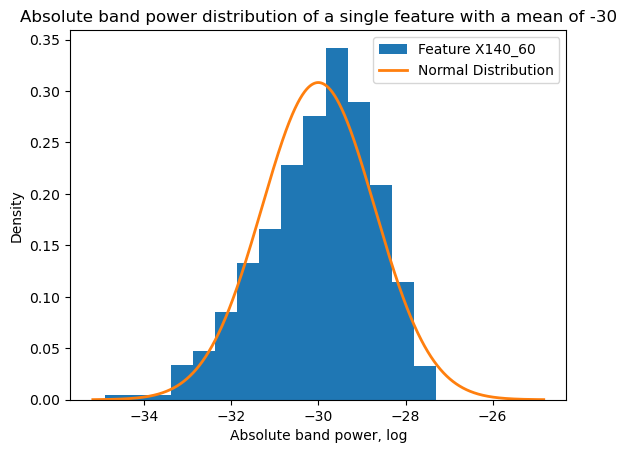

In [7]:
plot_distribution_with_normal(feature_matrix, feature = 866)

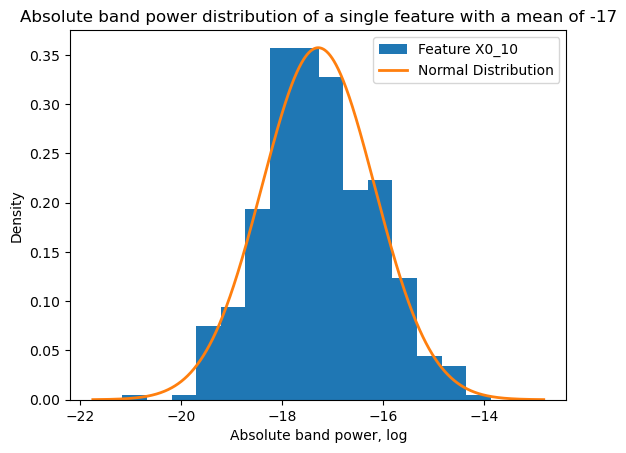

In [8]:
plot_distribution_with_normal(feature_matrix, feature = 0)

## Filter out non-informative features

Non-informative features will be filtered out before training the models. Non-informative features are those that have an extremely low coefficient of variation. For the data that is log-normally distributed an estimate of coefficient of variation is defined as:

$$\hat{cv} = \sqrt{e^{s^{2}_{ln}} - 1}$$

where $s_{ln}$ is the standard deviation of the data after a natural log transformation.

In [9]:
# Log-transform
x = np.log(feature_matrix.values)

# Center
x = x.T - np.mean(x, axis = 1)
x = x.T

cv = np.sqrt(np.power(np.e, np.power(np.std(x, axis = 1), 2)) - 1)
assert len(cv) != len(key)

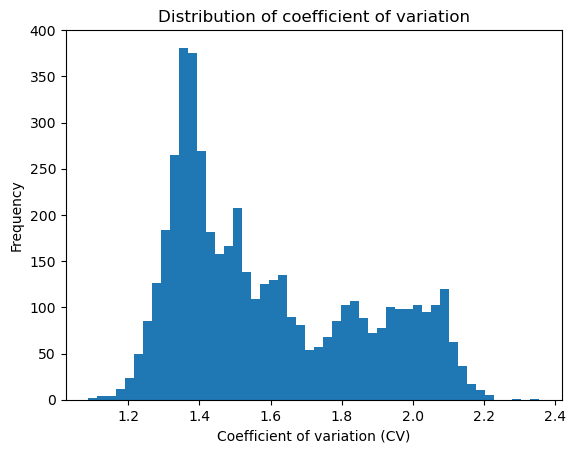

In [10]:
plt.hist(cv, bins = 50)
plt.xlabel('Coefficient of variation (CV)')
plt.ylabel('Frequency')
plt.title('Distribution of coefficient of variation')
plt.show()

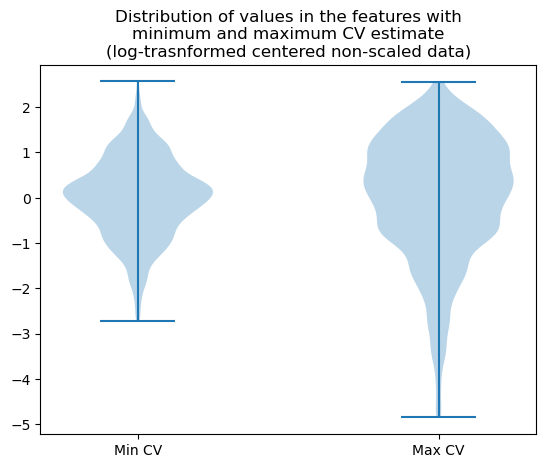

In [11]:
idx_max = np.argmax(cv)
idx_min = np.argmin(cv)

plt.violinplot(x[[idx_min, idx_max], :].T)
plt.title('Distribution of values in the features with\nminimum and maximum CV estimate\n(log-trasnformed centered non-scaled data)')
plt.xticks([1, 2], ['Min CV', 'Max CV'])
plt.show()

The CV seems quite high for all the features, and the data is well distributed for both the minimal and the maximal CV values. Seems like the features with low mean value carry some information and may be informative to the classifier.